In [28]:
! jupyter nbextension enable jupyter-black-master/jupyter-black

Enabling notebook extension jupyter-black-master/jupyter-black...
      - Validating: OK


In [175]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import deep_id_pytorch

from lstm_models import *
from model_utils import *

In [176]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## OPTIONS

In [177]:
nrows = 1000
min_freq = 1

train_data_path = "../../data/toy_dataset/data/train.csv"
valid_data_path = "../../data/toy_dataset/data/val.csv"

model_save_path = './sample_model/simple_lstm_201215'
results_save_path = "./sample_results/simple_results_201215"
batch_size = 64
n_epochs = 5

embedding_dim = 8
hidden_dim = 16
bidirectional = True
dropout = 0.3

target_colname = 'label'
uid_colname = 'patient_id'
x_inputs = [str(x) for x in range(29, -1, -1)]
target_value = '1'

seq_len = 30
rev = False

In [178]:
for fp in [model_save_path, results_save_path]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f'New directory created: {fp}')
        os.makedirs(os.path.split(fp)[0])

print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda available: True


## Create Vocab and Build Dataset

In [179]:
train_dataset, vocab = build_lstm_dataset(
                                train_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=None,
                                nrows=nrows,
                                rev=rev
                            )
valid_dataset, _ = build_lstm_dataset(
                                valid_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

Building dataset from ../../data/toy_dataset/data/train.csv..
Success!
Building dataset from ../../data/toy_dataset/data/val.csv..
Success!


In [180]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

## Model Training

In [181]:
model = SimpleLSTM(embedding_dim, hidden_dim, vocab, model_device)
model = model.cuda()

In [182]:
model

SimpleLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=2, bias=True)
)

In [183]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.9)

In [184]:
best_valid_loss = float("inf")
valid_worse_loss = 0  # enable early stopping
stop_num = 10

for epoch in range(n_epochs):

    start_time = time.time()

    train_loss, train_auc = epoch_train_lstm(
        model, train_dataloader, optimizer, loss_function
    )

    valid_loss, valid_auc = epoch_val_lstm(
       model, train_dataloader, loss_function)#, return_preds=False
    #)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
        print("Saved Model, epoch {}".format(epoch))
        valid_worse_loss = 0

    else:
        valid_worse_loss += 1
        if valid_worse_loss == stop_num:
            print("EARLY STOP ------")
            break

    scheduler.step()
    print(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} \t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.4f}"
    )

Epoch: 01 | Epoch Time: 0m 0s
Saved Model, epoch 0
Train Loss: 0.703 | Train AUC: 0.51 	 Val. Loss: 0.676 |  Val. AUC: 0.6364
Epoch: 02 | Epoch Time: 0m 0s
Saved Model, epoch 1
Train Loss: 0.576 | Train AUC: 0.77 	 Val. Loss: 0.373 |  Val. AUC: 0.9111
Epoch: 03 | Epoch Time: 0m 0s
Saved Model, epoch 2
Train Loss: 0.344 | Train AUC: 0.91 	 Val. Loss: 0.321 |  Val. AUC: 0.9269
Epoch: 04 | Epoch Time: 0m 0s
Saved Model, epoch 3
Train Loss: 0.320 | Train AUC: 0.92 	 Val. Loss: 0.314 |  Val. AUC: 0.9297
Epoch: 05 | Epoch Time: 0m 0s
Saved Model, epoch 4
Train Loss: 0.312 | Train AUC: 0.92 	 Val. Loss: 0.301 |  Val. AUC: 0.9377


## Get SHAP values

In [185]:
background = next(iter(train_dataloader))
background_ids, background_labels, background_idxes = background

In [186]:
background_idxes.shape

torch.Size([64, 30])

In [187]:
bg_data, bg_masks = model.get_all_ids_masks(background_idxes, 20)

In [188]:
bg_data.shape

torch.Size([64, 20, 32])

In [189]:
explainer = deep_id_pytorch.CustomPyTorchDeepIDExplainer(model, bg_data, bg_masks,
                                                         gpu_memory_efficient=True)

64it [00:00, 906.45it/s]


In [190]:
model.train() # in case that shap complains that autograd cannot be called
lstm_values = []
features = []
start = 0

In [191]:
test = list(train_dataloader)[3]
test_ids, test_labels, test_idxes = test

In [192]:
test_idxes[0]

tensor([ 6,  9, 19, 21,  8, 15, 11,  6, 31, 20,  8, 20, 19,  4,  6,  9, 11, 17,
        10,  5, 19,  9, 21,  3,  0,  0,  0,  0,  0,  0])

In [193]:
test_data, test_masks = model.get_all_ids_masks(test_idxes, 20)

In [194]:
test_data[0].shape

torch.Size([20, 32])

In [195]:
len(test_masks[0])

20

In [196]:
lstm_shap_values = explainer.shap_values(test_data[0].unsqueeze(0), test_masks[0])

128it [00:00, 332.25it/s]
128it [00:00, 323.93it/s]


In [197]:
class_token_values = [[] for _ in lstm_shap_values]

In [198]:
for (i, w) in enumerate(test_idxes[0, :20]):
    for c in range(len(lstm_shap_values)):
        class_token_values[c].append(lstm_shap_values[c][0, i, w])
lstm_values.append(class_token_values)
#features.append(tokens)

In [199]:
lstm_values

[[[0.2284105122089386,
   -0.08082426339387894,
   -0.002629045397043228,
   0.004059555474668741,
   -0.0038593264762312174,
   0.0010509488638490438,
   -0.0032367075327783823,
   -0.0005264503415673971,
   -0.004273338709026575,
   -0.0015388900646939874,
   -0.001204347820021212,
   -0.0015232681762427092,
   -0.0007353146211244166,
   -0.0008845474221743643,
   -0.00011129260383313522,
   -0.0005295959417708218,
   -0.00018938776338472962,
   8.620136213721707e-05,
   -4.8148353926080745e-06,
   7.940780778881162e-05],
  [-0.20028294622898102,
   0.06900153309106827,
   0.0019821343012154102,
   -0.003351386869326234,
   0.0035118544474244118,
   -0.0009849835187196732,
   0.0031067149247974157,
   0.00043689750600606203,
   0.004369432106614113,
   0.0014246178325265646,
   0.0010689113987609744,
   0.001300674513913691,
   0.0006396784447133541,
   0.0007616428774781525,
   9.332464833278209e-05,
   0.0004642837739083916,
   0.00017156547983177006,
   -7.333420944632962e-05,
   

In [200]:
np.array(lstm_values).shape

(1, 2, 20)

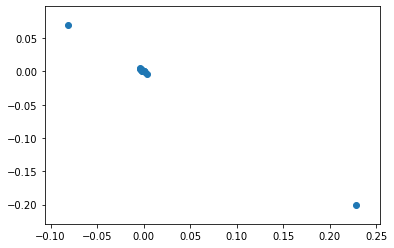

In [201]:
plt.scatter(lstm_values[0][0], lstm_values[0][1])

In [202]:
idx_seq = test_idxes[0, :20]
idx_seq

tensor([ 6,  9, 19, 21,  8, 15, 11,  6, 31, 20,  8, 20, 19,  4,  6,  9, 11, 17,
        10,  5])

In [203]:
idx_seq.numpy()[0]

6

In [204]:
model.vocab._rev_vocab

{0: '<pad>',
 1: '<unk>',
 2: 'normal_bmi',
 3: 'dental_exam',
 4: 'backache',
 5: 'eye_exam',
 6: 'quad_injury',
 7: 'cold_sore',
 8: 'hay_fever',
 9: 'peanut_allergy',
 10: 'annual_physical',
 11: 'cut_finger',
 12: 'myopia',
 13: 'ACE_inhibitors',
 14: 'foot_pain',
 15: 'headache',
 16: 'resistent_hyp',
 17: 'high_creatinine',
 18: 'furosemide',
 19: 'ACL_tear',
 20: 'ankle_sprain',
 21: 'ingrown_nail',
 22: 'cardiac_rehab',
 23: 'low_salt_diet',
 24: 'pneumonia',
 25: 'apnea',
 26: 'PCI',
 27: 'tachycardia',
 28: 'CHF',
 29: 'ARR',
 30: 'PH',
 31: 'AMI'}

In [205]:
events = [model.vocab.itos(x) for x in idx_seq.numpy()]
print(events)

['quad_injury', 'peanut_allergy', 'ACL_tear', 'ingrown_nail', 'hay_fever', 'headache', 'cut_finger', 'quad_injury', 'AMI', 'ankle_sprain', 'hay_fever', 'ankle_sprain', 'ACL_tear', 'backache', 'quad_injury', 'peanut_allergy', 'cut_finger', 'high_creatinine', 'annual_physical', 'eye_exam']


In [206]:
#model.vocab._vocab

In [207]:
lstm_values[0][0]

[0.2284105122089386,
 -0.08082426339387894,
 -0.002629045397043228,
 0.004059555474668741,
 -0.0038593264762312174,
 0.0010509488638490438,
 -0.0032367075327783823,
 -0.0005264503415673971,
 -0.004273338709026575,
 -0.0015388900646939874,
 -0.001204347820021212,
 -0.0015232681762427092,
 -0.0007353146211244166,
 -0.0008845474221743643,
 -0.00011129260383313522,
 -0.0005295959417708218,
 -0.00018938776338472962,
 8.620136213721707e-05,
 -4.8148353926080745e-06,
 7.940780778881162e-05]

In [208]:
len(lstm_values[0][0])

20

In [209]:
events

['quad_injury',
 'peanut_allergy',
 'ACL_tear',
 'ingrown_nail',
 'hay_fever',
 'headache',
 'cut_finger',
 'quad_injury',
 'AMI',
 'ankle_sprain',
 'hay_fever',
 'ankle_sprain',
 'ACL_tear',
 'backache',
 'quad_injury',
 'peanut_allergy',
 'cut_finger',
 'high_creatinine',
 'annual_physical',
 'eye_exam']

In [210]:
df = pd.DataFrame()
df['events'] = events
df['shap_vals'] = lstm_values[0][0]

In [211]:
df

,events,shap_vals
0,quad_injury,0.228411
1,peanut_allergy,-0.080824
2,ACL_tear,-0.002629
3,ingrown_nail,0.004060
4,hay_fever,-0.003859
5,headache,0.001051
6,cut_finger,-0.003237
7,quad_injury,-0.000526
8,AMI,-0.004273
9,ankle_sprain,-0.001539


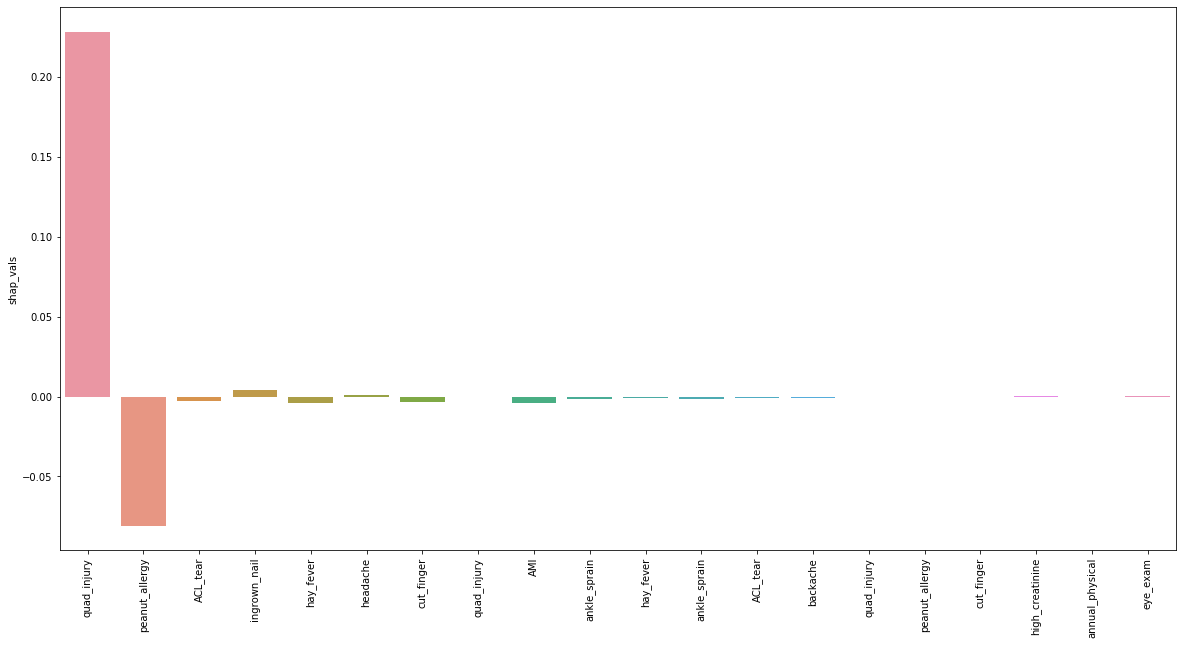

In [212]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=df.index, y=df.shap_vals, orient='v')
z = ax.set_xticklabels(df.events, rotation=90)